# A/B tests

This notebook provides the code for `Ch. 16 A/B tests`

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
import matplotlib.colors as colors
import cycler

from scipy.stats import gaussian_kde
import statsmodels.api as sm
from scipy import stats


# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {'titlesize' : 22,
        'labelsize' : 20,
       'prop_cycle' : cycler.cycler(color='k')}
lines = {'color' : 'k'}
figure = {'figsize' : (10,4),
         'autolayout' : True,}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)
matplotlib.rc('lines', **lines)


In [16]:
def test_ab(y,D, verbose = False):
    """Use a t-test and a regression to check if treatment is incremental
    You only need one of these.  Here I'm using both so that you can check
    that the results from a standard t-test and a regression are exactly
    the same
    """
    # regression: get coefficient and p-value
    xmat = D
    xmat = sm.add_constant(xmat)
    mod = sm.OLS(y, xmat).fit()
    pval = mod.pvalues[1]
    tstat = mod.tvalues[1]
    pval_for_repor = pval.round(decimals=2)
    coef = mod.params[1]
    coef_for_repor = coef.round(decimals=2)
    mean_control = mod.params[0].round(decimals=2)
    mean_treatment = (mean_control + coef).round(decimals=2)
    var_beta = mod.cov_params()[1,1]
    tstat = coef/np.sqrt(var_beta)
    mypval = 2*(1-stats.t.cdf(x=np.abs(tstat), df=mod.df_resid))
    # t=test
    y0 = y[D==0]
    y1 = y[D==1]
    mean0 = np.mean(y0).round(decimals=2)
    mean1 = np.mean(y1).round(decimals=2)
    delta = (mean1 - mean0).round(decimals=2)
    ttest = stats.ttest_ind(y0, y1)
    if verbose:
        print('--------------------------------')
        print(f'OLS: slope = {coef_for_repor}, pval = {pval_for_repor}')
        print(f"""Means: control = {mean_control}, treatment = {mean_treatment}""")
        print('--------------------------------')
        print('--------------------------------')
        print(f't-test: slope = {delta}, pval = {ttest.pvalue.round(decimals=2)}')
        print(f'Means: control = {mean0}, treatment = {mean1}')
        print('--------------------------------')
    
    return coef, tstat, pval

Text(0.83, 0.8, 'Rejection Zone')

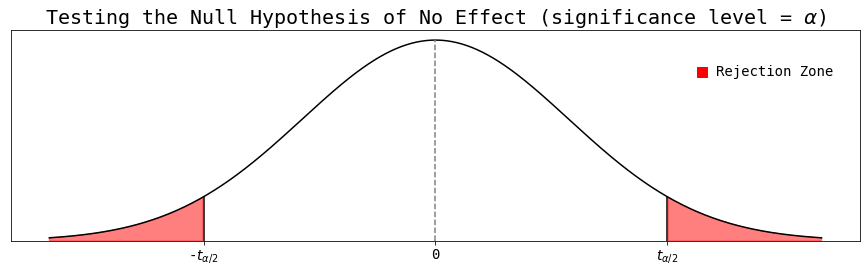

In [17]:
# get some plots for the chapter
# 1. Signficance level
seed = 73091
np.random.seed(seed)
grid_x = np.linspace(-2.9, 2.9, 600)
fig, ax = plt.subplots(figsize=(13,4))
pdf = stats.norm.pdf(grid_x)
ax.plot(grid_x, pdf)
ax.plot([0,0], [0,stats.norm.pdf(0)], color = '0.5', ls='--')
pct = np.quantile(grid_x, 0.80)
ax.plot([pct, pct], [0, stats.norm.pdf(pct)])
ax.plot([-pct, -pct], [0, stats.norm.pdf(-pct)])
ax.fill_between(grid_x, pdf, where=np.logical_or(grid_x>=pct,grid_x<=-pct), color='r', alpha=0.5)
#ax.fill_between(grid_x, pdf, where=grid_x>=pct, color='r', alpha=0.5)
ymin, ymax = ax.get_ylim()
ax.set_ylim([0,ymax])
a = ax.set_xticks([-pct, 0,pct])
#a = ax.set_xticks([0,pct])
a = ax.set_yticks([])
a = ax.set_xticklabels([r"-$t_{\alpha/2}$",0,r"$t_{\alpha/2}$"])
#a = ax.set_xticklabels([0,r"$t_{\alpha}$"])
a = ax.set_yticklabels([])
ax.set_title(r'Testing the Null Hypothesis of No Effect (significance level = $\alpha$)', fontsize=20)
ax.scatter(2,0.8*ymax, marker='s', s = 100, color='r')
plt.text(0.83, 0.8, 'Rejection Zone',ha='left',va='center',transform = ax.transAxes)

Text(0.5, 1.0, 'False Positives and False Negatives')

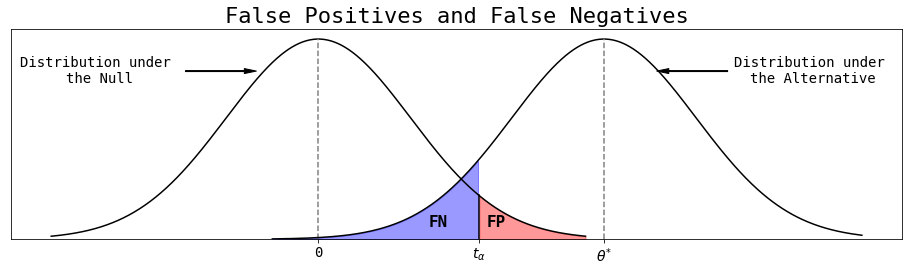

In [18]:
# Statistical power and size (significance)
fig, ax = plt.subplots(figsize=(13,4))
# first size
ax.plot(grid_x, pdf)
ax.plot([0,0], [0,stats.norm.pdf(0)], color = '0.5', ls='--')
pct = np.quantile(grid_x, 0.80)
ax.plot([pct, pct], [0, stats.norm.pdf(pct)])
ax.fill_between(grid_x, pdf, where=grid_x>=pct, color='r', alpha=0.4)
grid_x1 = np.linspace(-0.5, 5.9, 600)
mean1 = 3.1
pdf1 = stats.norm.pdf(grid_x1, loc=mean1)
ax.set_xticks([0,pct, mean1])
ax.set_xticklabels([0,r'$t_{\alpha}$',r'$\theta^{*}$'])
ax.fill_between(grid_x1, pdf1, where=grid_x1<=pct, color='b', alpha=0.4)
ax.plot(grid_x1, pdf1)
ax.plot([mean1,mean1], [0,stats.norm.pdf(mean1, loc=mean1)], color = '0.5', ls='--')
ax.set_yticks([])
ax.set_yticklabels([])
ymin, ymax = ax.get_ylim()
ax.set_ylim([0,ymax])
# some text and annotations
ax.annotate('Distribution under \nthe Null', xy=(0.28, 0.8), xytext=(0.1, 0.8), 
            xycoords='axes fraction',textcoords='axes fraction', ha='center',va='center',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
ax.annotate('Distribution under \nthe Alternative', xy=(0.72, 0.8), xytext=(0.9, 0.8), 
            xycoords='axes fraction',textcoords='axes fraction', ha='center',va='center',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

ax.text(0.48,0.08, 'FN',transform=ax.transAxes, fontsize=16, weight='bold', ha='center',va='center')
ax.text(0.545,0.08, 'FP',transform=ax.transAxes, fontsize=16, weight='bold', ha='center',va='center')

ax.set_title('False Positives and False Negatives')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


Text(0.5, 1.0, 'Minimum Detectable Effect (Unit Variances)')

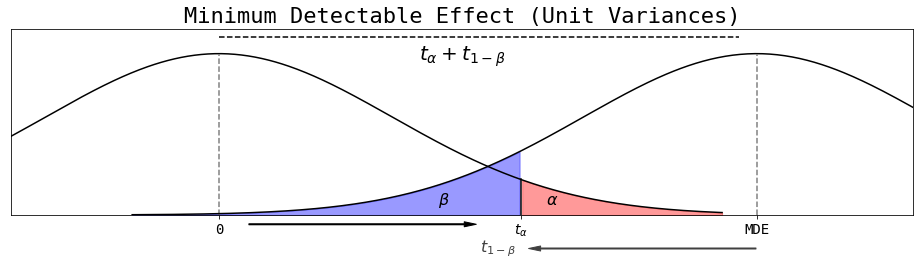

In [19]:
# MDE
fig, ax = plt.subplots(figsize=(13,4))
# first size
ax.plot(grid_x, pdf)
ax.plot([0,0], [0,stats.norm.pdf(0)], color = '0.5', ls='--')
pct = np.quantile(grid_x, 0.80)
ax.plot([pct, pct], [0, stats.norm.pdf(pct)])
ax.fill_between(grid_x, pdf, where=grid_x>=pct, color='r', alpha=0.4)
grid_x1 = np.linspace(-0.5, 5.9, 600)
mean1 = 3.1
pdf1 = stats.norm.pdf(grid_x1, loc=mean1)
ax.set_xticks([0,pct, mean1])
ax.set_xticklabels([0,r'$t_{\alpha}$',r'MDE'])
ax.fill_between(grid_x1, pdf1, where=grid_x1<=pct, color='b', alpha=0.4)
ax.plot(grid_x1, pdf1)
ax.plot([mean1,mean1], [0,stats.norm.pdf(mean1, loc=mean1)], color = '0.5', ls='--')
ax.set_yticks([])
ax.set_yticklabels([])
ymin, ymax = ax.get_ylim()
max_y = 1.05*ymax
ax.set_ylim([0,1.1*ymax])
ax.set_xlim([-1.2,4.0])
# some text and annotations
ax.text(0.48,0.08, r'$\beta$',transform=ax.transAxes, fontsize=16, weight='bold', ha='center',va='center')
ax.text(0.6,0.08, r'$\alpha$',transform=ax.transAxes, fontsize=16, weight='bold', ha='center',va='center')
# arrow to the left
low_arr = -0.18
color = '0.25'
ax.annotate('', xy=(0.56, low_arr), xytext=(0.84, low_arr), 
            xycoords='axes fraction',textcoords='axes fraction', ha='center',va='center',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, color=color))
ax.text(0.54,low_arr, r'$t_{1-\beta}$', color = color,
        transform=ax.transAxes, fontsize=16, weight='bold', ha='center',va='center')
# arrow to the right
low_arr = -0.05
ax.annotate('', xy=(0.53, low_arr), xytext=(0.25, low_arr), 
            xycoords='axes fraction',textcoords='axes fraction', ha='center',va='center',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))

ax.plot([0,3],[max_y,max_y], ls='--')
ax.text(0.5,0.85,r'$t_{\alpha} + t_{1-\beta}$', transform = ax.transAxes, ha='center', va='center', fontsize=20)

ax.set_title('Minimum Detectable Effect (Unit Variances)')


In [20]:
def compute_mde(sample_size, var_outcome, size=0.05, power = 0.85):
    "Compute MDE"
    df = 1000  # this can be come from your data, or can be set large enough like I'm doing here
    t_alpha = stats.t.ppf(1-size, df)
    t_oneminusbeta = stats.t.ppf(power, df)
    p = 0.5
    MDE = (t_alpha + t_oneminusbeta)*np.sqrt(var_outcome/(sample_size*p*(1-p)))
    return MDE

def compute_sample_size(mde, var_outcome, size=0.05, power = 0.85):
    "Alternatively, solve for the sample size given an MDE"
    df = 1000  # this can be come from your data, or can be set large enough like I'm doing here
    t_alpha = stats.t.ppf(1-size, df)
    t_oneminusbeta = stats.t.ppf(power, df)
    sum_t = t_alpha + t_oneminusbeta
    p = 0.5
    sample_size = var_outcome/(p*(1-p))*(sum_t**2/mde**2)
    return sample_size

# test the functions: F^{-1}(F(N)) = N
smp_sze = 100.0
test_size = compute_sample_size(mde=compute_mde(sample_size=smp_sze, var_outcome=1), var_outcome=1)
assert smp_sze == test_size.round()

# let's plot the relation
N_grid = range(int(1e2),int(1e3),10)
mde_grid1 = [compute_mde(sample_size=sze, var_outcome=1) for sze in N_grid]
mde_grid05 = [compute_mde(sample_size=sze, var_outcome=0.5) for sze in N_grid]
mde_grid5 = [compute_mde(sample_size=sze, var_outcome=2.5) for sze in N_grid]

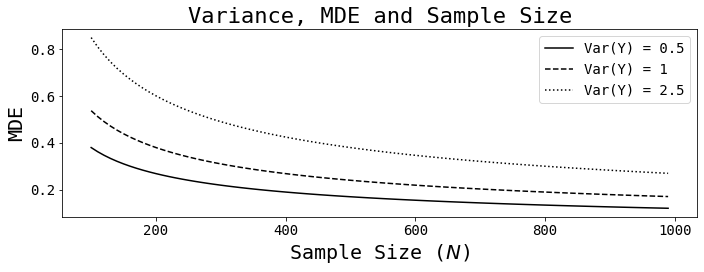

In [21]:
fig, ax = plt.subplots()
ax.plot(N_grid, mde_grid05, ls='-')
ax.plot(N_grid, mde_grid1, ls='--')
ax.plot(N_grid, mde_grid5, ls='dotted')
ax.set_xlabel(r'Sample Size ($N$)')
ax.set_ylabel('MDE')
ax.set_title('Variance, MDE and Sample Size')
ax.legend([r'Var(Y) = 0.5', r'Var(Y) = 1', r'Var(Y) = 2.5'])

Text(0, 0.5, 'Sample Size')

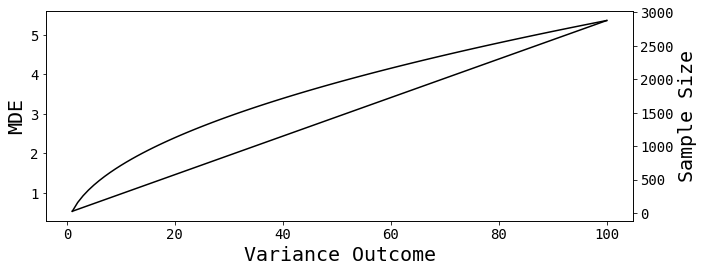

In [22]:
var_grd = np.linspace(1,100,100)
mde_var = [compute_mde(sample_size=100, var_outcome=var) for var in var_grd]
sze_var = [compute_sample_size(mde=1, var_outcome=var) for var in var_grd]
fig, ax = plt.subplots()
ax.plot(var_grd, mde_var)
ax1 = ax.twinx()
ax1.plot(var_grd, sze_var)
ax.set_xlabel('Variance Outcome')
ax.set_ylabel('MDE')
ax1.set_ylabel('Sample Size')

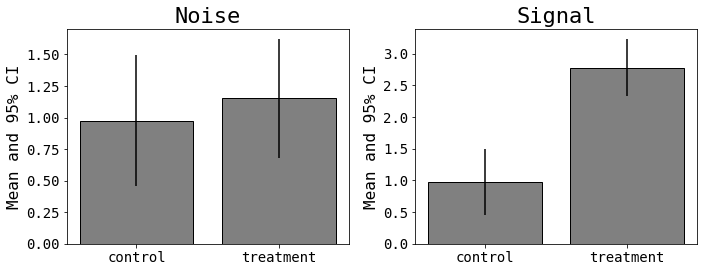

In [23]:
# Signal vs. noise
fig, ax = plt.subplots(1,2)
# plot 1: same distribution different draws
seed = 95412
nobs = 20
np.random.seed(seed)
draw1 = 1 + np.random.randn(nobs)
avg1 = np.mean(draw1)
sd1 = 1.96*stats.sem(draw1)
pdf1 = stats.norm.pdf(draw1)
draw2 = 1 + np.random.randn(nobs)
pdf2 = stats.norm.pdf(draw2)
avg2 = np.mean(draw2)
sd2 = 1.96*stats.sem(draw2)
ax[0].bar([0,1],[avg1, avg2], edgecolor='k', facecolor='0.5', yerr= [sd1, sd2])
ax[0].set_title('Noise')
# plot 2: different distributions
draw3 = 3.0 + np.random.randn(nobs)
pdf3 = stats.norm.pdf(draw3)
avg3 = np.mean(draw3)
sd3 = 1.96*stats.sem(draw3)
ax[1].bar([0,1],[avg1, avg3], edgecolor='k', facecolor='0.5', yerr = [sd1, sd3])
ax[1].set_title('Signal')
for i in range(2):
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(['control', 'treatment'])
    ax[i].set_ylabel(r'Mean and 95% CI', fontsize = 16)


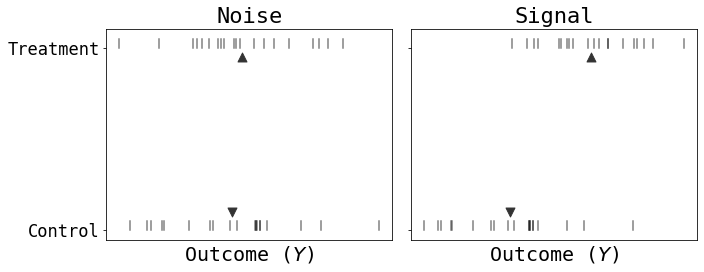

In [24]:
# try a different plot
fig, ax = plt.subplots(1,2)
dict_p = {0:[draw1, draw2], 1:[draw1, draw3]}
dict_d = {0:[pdf1, pdf2], 1:[pdf1, pdf3]}
list_ttl = ['Noise', 'Signal']
G = 0.1
for i in range(2):
    y1, y2 = dict_p[i]
    for j in range(len(y1)):
        ax[i].plot([y1[j],y1[j]],[0,0+G], alpha=0.5)
        ax[i].plot([y2[j],y2[j]],[2,2+G], alpha=0.5)
    # means
    marker_up = '^'
    marker_dn = 'v'
    size =80
    ax[i].scatter(np.mean(y1),0.2, color = '0.2', marker=marker_dn, s=size)
    ax[i].scatter(np.mean(y2),1.9, color = '0.2', marker=marker_up, s=size)
        
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([0,2])
    ax[i].set_yticklabels([])
    if i==0:
        ax[i].set_yticklabels(['Control','Treatment'], fontsize=17)
    ax[i].set_xlabel(r'Outcome ($Y$)')
    ax[i].set_title(list_ttl[i])

In [25]:
# Let's run through this example
df = pd.DataFrame(np.array([draw1, draw2]).T, columns = ['control', 'treatment'])
ix10 = df.index[:10]
df10 = df.loc[ix10]
# use test_ab function
y = np.concatenate((draw1[:10], draw2[:10]))
D = 1*np.in1d(y,draw2[:10])
diff, tstat_o, pval = test_ab(y,D, verbose=False)
print('-'*60)
print('RESULTS FROM OLS')
print(f'diff = {diff}, tstat = {tstat_o}, pval = {pval}')
print('-'*60)
# but also compute everything by hand
# 1. Means and difference in means
mean1 = np.mean(y[D==1])
mean0 = np.mean(y[D==0])
theta = np.mean(y[D==1]) - np.mean(y[D==0])
print('CALCULATING EVERYTHING BY HAND')
print(f'mean1 = {mean1.round(decimals=2)}, mean0 = {mean0.round(decimals=2)}, theta = {theta.round(decimals=2)}')
# variance of theta
var1 = np.var(y[D==1],ddof=1)
var0 = np.var(y[D==0],ddof=1)
Nt, Nc = len(y[D==1]), len(y[D==0])
N = Nt + Nc
P = Nt/N
var_theta = var1/Nt + var0/Nc
se_theta = np.sqrt(var_theta)
print(f'var = {var_theta.round(decimals=3)}')
# t-statistic
tstat = theta/se_theta
print(f't-statistic = {tstat}')
# pvalue
dof = N-2
pval = 2*(1-stats.t.cdf(x=np.abs(tstat), df=dof))
print(f'P-value = {pval}')

# check with stats.ttest_ind
# use stats
stats.ttest_ind(a=y[D==1], b=y[D==0], equal_var=True)

------------------------------------------------------------
RESULTS FROM OLS
diff = -0.20714141801113148, tstat = -0.43758946458055753, pval = 0.666889301473263
------------------------------------------------------------
CALCULATING EVERYTHING BY HAND
mean1 = 0.84, mean0 = 1.05, theta = -0.21
var = 0.224
t-statistic = -0.43758946458055736
P-value = 0.6668893014732631


Ttest_indResult(statistic=-0.43758946458055736, pvalue=0.6668893014732631)

## Check that MDE formula works
* Simulate a model with a true effect that is smaller than MDE

In [37]:
# let's simulate a model and check that the MDE formula works
def simulate_model(nobs, seed, true_effect, var_epsilon):
    "Simulate a linear model for a treatment effect"
    np.random.seed(seed)
    epsilon = np.sqrt(var_epsilon)*np.random.randn(nobs)
    # Draw bernoulli trials for the treatment dummy variable
    D = np.random.binomial(n=1, p=0.5, size=nobs)
    intercept = 1
    y = intercept + D*true_effect + epsilon
    return y, D

def run_mc_mde(y,D,size,B):
    nobs = len(y)
    df_pos = pd.DataFrame(index=range(B), columns = ['theta','tpr','fnr'], dtype = 'float')
    for b in range(B):
        ix_g = np.random.choice(nobs,size=size, replace=True)
        yg, Dg = y[ix_g], D[ix_g]
        eff_g, tstat_g, pval_g = test_ab(yg, Dg, verbose = False)
        flag_tp = 1*(pval_g<=0.05)  # true positives or false positive
        flag_fn = 1*(pval_g>0.05)  # false negatives or true negative
        df_pos.loc[b] = [eff_g, flag_tp, flag_fn]
    mean_pos = df_pos.mean()
    return mean_pos

In [38]:
var_epsilon = 3
nobs = 500
seed = 62910
true_effect = 0.5
y, D = simulate_model(nobs, seed, true_effect, var_epsilon)
vary = np.var(y, ddof=1)
min_size = compute_sample_size(mde=true_effect, var_outcome=var_epsilon, size=0.05, power = 0.85)
print(f'Sample Size (MDE) = {min_size}')
grid_size = [int(sze) for sze in np.arange(0.5*min_size, 1.5*min_size,10)]
pval_df = pd.DataFrame(index=grid_size, columns = ['theta','tpr','fnr'])
for g,nsze in enumerate(grid_size):
    eff_g, tpr_g, fnr_g = run_mc_mde(y,D,size=nsze,B=300)
    pval_df.loc[nsze] = [eff_g, tpr_g, fnr_g]


Sample Size (MDE) = 345.61760816175865


Text(0.5, 0, 'Sample Size (N)')

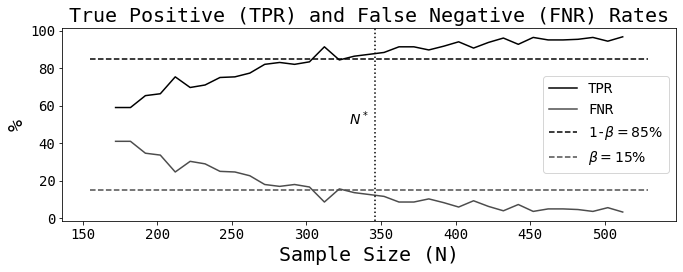

In [82]:
fig, ax = plt.subplots()
cols = ['tpr','fnr']
roll_avg = 100*pval_df[cols].rolling(window=1).mean()
roll_avg.plot(color=['k','0.3'], ax=ax)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.set_ylim([ymin,ymax])
ax.plot([xmin,xmax],[85,85], ls='--', color='k')
ax.plot([xmin,xmax],[15,15], ls='--', color='0.3')
ax.set_title('True Positive (TPR) and False Negative (FNR) Rates', fontsize=20)
ax.legend(['TPR','FNR',r'1-$\beta =85\%$', r'$\beta =15\%$'])
ax.plot([min_size, min_size],[ymin, ymax], ls='dotted')
ax.text(0.5,0.5,r'$N^*$', transform = ax.transAxes, ha='right')
ax.set_ylabel('%')
ax.set_xlabel('Sample Size (N)')

In [32]:
# repeat, but now, no effect
var_epsilon = 3
nobs = 500
true_effect = 0
y, D = simulate_model(nobs, seed, true_effect, var_epsilon)
vary = np.var(y, ddof=1)
#min_size = compute_sample_size(mde=true_effect, var_outcome=var_epsilon, size=0.05, power = 0.85)
#print(f'Sample Size (MDE) = {min_size}')
grid_size = [int(sze) for sze in np.arange(10, nobs,10)]
pval_df1 = pd.DataFrame(index=grid_size, columns = ['theta','tpr','fnr'])
for g,nsze in enumerate(grid_size):
    eff_g, tpr_g, fnr_g = run_mc_mde(y,D,size=nsze,B=300)
    pval_df1.loc[nsze] = [eff_g, tpr_g, fnr_g]


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'False Positive (FPR) and True Negative (TNR) Rates')

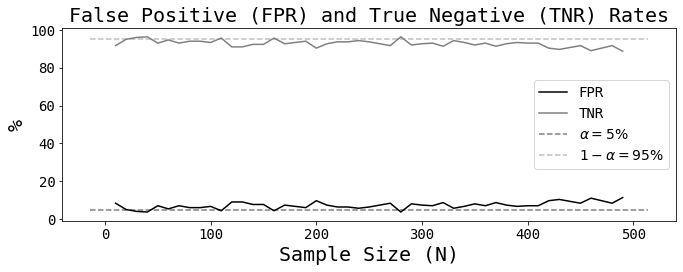

In [83]:
fig, ax = plt.subplots()
roll_avg = 100*pval_df1[cols].rolling(window=1).mean()
roll_avg.plot(color=['k','0.5'], ax=ax)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.set_ylim([ymin,ymax])
ax.plot([xmin,xmax],[5,5], ls='--', color='k', alpha=0.5)
ax.plot([xmin,xmax],[95,95], ls='--', color='0.5', alpha=0.5)
ax.legend(['FPR','TNR',r'$\alpha =5\%$', r'$1-\alpha =95\%$'])
ax.set_ylabel('%')
ax.set_xlabel('Sample Size (N)')
ax.set_title('False Positive (FPR) and True Negative (TNR) Rates', fontsize=20)


MDE = 0.03325622266760955 for sample size = 1000.0
Your new conversion rate is = 7.3256%
MDE = 0.010516541000336697 for sample size = 10000.0
Your new conversion rate is = 5.0517%
MDE = 0.0010516541000336697 for sample size = 1000000.0
Your new conversion rate is = 4.1052%
MDE = 3.325622266760956e-05 for sample size = 1000000000.0
Your new conversion rate is = 4.0033%


Text(0.4, 0.8, 'Baseline CR = 4%')

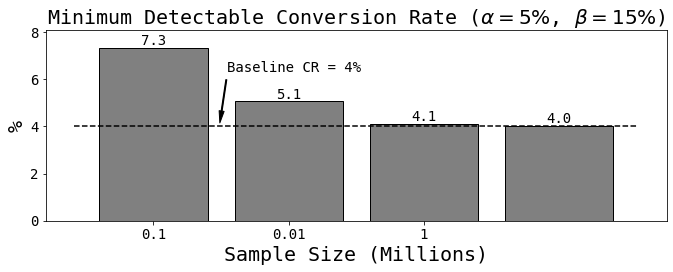

In [137]:
# example for conversion rate
c_rate = 0.04
var_outcome = c_rate*(1-c_rate)
fig, ax = plt.subplots()
for s,smp in enumerate([1e3, 1e4, 1e6, 1e9]):
    mde = compute_mde(sample_size=smp, var_outcome=var_outcome, size=0.05, power = 0.85)
    print(f'MDE = {mde} for sample size = {smp}')
    new_crate = 100*(c_rate+mde)
    print(f'Your new conversion rate is = {new_crate.round(decimals=4)}%')
    
    ax.bar(s,new_crate, edgecolor='k', facecolor='0.5')
    ax.text(s,new_crate, str(new_crate.round(decimals=1)), ha='center',va='bottom')

ax.set_xticks(range(3))
ax.set_xticklabels(['0.1', '0.01','1','1000'])
ax.set_title(r'Minimum Detectable Conversion Rate ($\alpha=5\%$, $\beta=15\%$)', fontsize=20)
ax.set_xlabel('Sample Size (Millions)')
xmin, xmax = ax.get_xlim()
ax.plot([xmin, xmax], 100*np.array([c_rate, c_rate]), '--')
ymin, ymax = ax.get_ylim()
ax.set_ylim([0,1.05*ymax])
ax.set_ylabel('%')
ax.annotate('Baseline CR = 4%', xytext=(0.4, 0.8), xy=(0.28, 0.5), 
            xycoords='axes fraction',textcoords='axes fraction', ha='center',va='center',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
